# Training a neural network with McSnow output

This script applies a DNN to a regression problem 

Much of this follows the basic regression example from the Tensorflow tutorial

https://www.tensorflow.org/tutorials/keras/regression


In [1]:
version = '14'

### Load Tensorflow and other useful modules

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import pathlib

import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


In [3]:
tf.random.set_seed(1234)

### Load data from netcdf

In [4]:
import numpy as np
import xarray as xr

In [5]:
mdir='/Users/axel/DWD/GITLAB/mcsnow/'
edir='experiments/'

data="graupel"

fname1=mdir+edir+'icebox_train_rc_'+data+'.nc'

ds1 = xr.open_dataset(fname1)
print('ds1: ', ds1)

ds1:  <xarray.Dataset>
Dimensions:                   (cell: 2684736)
Dimensions without coordinates: cell
Data variables: (12/97)
    time                      (cell) float32 ...
    q_cloud                   (cell) float32 ...
    n_cloud                   (cell) float32 ...
    q_rain                    (cell) float32 ...
    n_rain                    (cell) float32 ...
    q_ice                     (cell) float32 ...
    ...                        ...
    frze_graupel_rain_mass    (cell) float32 ...
    frze_graupel_rain_rmass   (cell) float32 ...
    frze_graupel_rain_rvol    (cell) float32 ...
    frze_graupel_rain_liq     (cell) float32 ...
    rime_graupel_rain_num     (cell) float32 ...
    rime_graupel_rain_mass    (cell) float32 ...
Attributes:
    title:    McSnow ice microphysics box model output pre-processed by NCL
    date:     So  5 Jun 2022 13:37:07 CEST
    nfiles:   18051


# Prepare data for training

In [6]:
def read_and_prepare_data(fname):
    # Read some data, we just want simple nparrays. Hence the .values
    temp = xr.open_dataset(fname).temp.values
    rho  = xr.open_dataset(fname).rho.values
    q_g  = xr.open_dataset(fname).q_graupel.values
    num_g  = xr.open_dataset(fname).n_graupel.values
    rime_g = xr.open_dataset(fname).rime_graupel.values
    rvol_g = xr.open_dataset(fname).rvol_graupel.values
    liq_g  = xr.open_dataset(fname).liq_graupel.values
    # process rates
    melt_liq   = xr.open_dataset(fname).melt_graupel_mass.values   # this is the total ice->liq rate
    # rescale process rate with temperature 
    t_3 = 273.15
    melt_liq= np.where(temp > t_3, melt_liq/(temp-t_3), np.nan)
    # some numerical lower bounds
    q_min = 1e-15
    n_min = 1e-15
    z_min = 1e-20
    p_min = 1e-20
    # use liquid water fraction 
    liq_g = np.where(q_g>q_min,liq_g/q_g,np.nan)  
    liq_g = np.where(liq_g>0.0,liq_g,np.nan)  
    # transform everything in log space
    q_g = np.log(q_g, where=q_g>q_min, out=np.nan*q_g)
    num_g  = np.log(num_g,  where=num_g>n_min, out=np.nan*q_g)
    rime_g = np.log(rime_g, where=rime_g>q_min, out=np.nan*q_g)
    rvol_g = np.log(rvol_g, where=rvol_g>q_min, out=np.nan*q_g)
    melt_liq = np.log(melt_liq,  where=melt_liq>p_min,  out=np.nan*melt_liq)
    # put everything in a pandas dataframe
    dataset = pd.DataFrame(np.array( [ q_g, num_g, rime_g, rvol_g, liq_g, melt_liq ]))
    dataset = dataset.T
    dataset.columns = [ 'q_g', 'num_g', 'rime_g', 'rvol_g', 'liq_g', 'melt_liq' ] 
    # remove missing values immediately
    dataset = dataset.dropna()
    return dataset

In [7]:
df = read_and_prepare_data(fname1)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in greater


In [8]:
df.describe()

q_g          num_g         rime_g         rvol_g  \
count  809593.000000  809593.000000  809593.000000  809593.000000   
mean       -7.846562       1.610996      -8.515106     -15.099491   
std         4.239403       5.008448       4.614006       4.645356   
min       -23.025650     -14.498609     -28.457630     -34.535980   
25%        -9.997688      -0.960217     -11.180676     -17.734407   
50%        -6.181367       3.163152      -6.779978     -13.377514   
75%        -4.705764       5.135034      -4.984529     -11.538377   
max        -3.506558      10.744515      -3.509128      -8.906243   

               liq_g       melt_liq  
count  809593.000000  809593.000000  
mean        0.354714     -14.620705  
std         0.300091       4.108331  
min         0.000004     -32.988365  
25%         0.095205     -16.241253  
50%         0.268108     -12.780009  
75%         0.595481     -12.004348  
max         1.000000      -7.452862

In [9]:
msk = np.random.rand(len(df)) < 0.7
dataset_train = df[msk]

df2 = df[~msk]
msk = np.random.rand(len(df2)) < 0.5

dataset_test = df2[msk]
dataset_val = df2[~msk]

### Inspect the data

In [10]:
dataset_train.head()

q_g     num_g     rime_g     rvol_g     liq_g   melt_liq
95  -13.692320  1.847478 -13.737347 -19.790590  0.002395 -17.415735
97  -13.691966  1.847478 -13.743097 -19.796471  0.008427 -17.497498
98  -13.753945  1.786546 -13.809429 -19.872475  0.012764 -17.541636
99  -13.753663  1.786546 -13.814511 -19.877699  0.018038 -17.624657
100 -13.753381  1.786546 -13.820463 -19.883856  0.024212 -17.622187

In [11]:
dataset_train.describe()

q_g          num_g         rime_g         rvol_g  \
count  566641.000000  566641.000000  566641.000000  566641.000000   
mean       -7.847941       1.615214      -8.517221     -15.101678   
std         4.239519       5.004387       4.615501       4.646991   
min       -23.025650     -14.498609     -28.141714     -34.535980   
25%        -9.995054      -0.956254     -11.179959     -17.734558   
50%        -6.184515       3.164926      -6.780418     -13.379517   
75%        -4.707247       5.137562      -4.986357     -11.540225   
max        -3.506558      10.744515      -3.509128      -8.906318   

               liq_g       melt_liq  
count  566641.000000  566641.000000  
mean        0.354885     -14.621314  
std         0.300252       4.108954  
min         0.000004     -32.882854  
25%         0.095180     -16.243561  
50%         0.268243     -12.781025  
75%         0.595799     -12.004153  
max         1.000000      -7.488423

In [12]:
dataset_test.describe()

q_g          num_g         rime_g         rvol_g  \
count  121744.000000  121744.000000  121744.000000  121744.000000   
mean       -7.857585       1.583534      -8.523272     -15.108017   
std         4.250226       5.031985       4.620385       4.651176   
min       -23.017189     -14.498609     -28.457630     -34.526356   
25%       -10.075445      -1.050808     -11.245822     -17.798829   
50%        -6.180931       3.148496      -6.782313     -13.380810   
75%        -4.702127       5.131451      -4.979166     -11.532012   
max        -3.506591      10.697588      -3.511570      -8.906243   

               liq_g       melt_liq  
count  121744.000000  121744.000000  
mean        0.353759     -14.630505  
std         0.299370       4.117203  
min         0.000005     -32.988365  
25%         0.095269     -16.301931  
50%         0.266610     -12.777952  
75%         0.593879     -11.998962  
max         0.999962      -7.452862

In [13]:
dataset_val.describe()

q_g          num_g         rime_g         rvol_g  \
count  121208.000000  121208.000000  121208.000000  121208.000000   
mean       -7.829052       1.618861      -8.497018     -15.080719   
std         4.227939       5.003679       4.600573       4.631832   
min       -23.025650     -14.498609     -28.387684     -34.517895   
25%        -9.933354      -0.882856     -11.124827     -17.672702   
50%        -6.166318       3.170274      -6.774143     -13.366029   
75%        -4.701387       5.125778      -4.980715     -11.536150   
max        -3.506791      10.705893      -3.511369      -8.906908   

               liq_g       melt_liq  
count  121208.000000  121208.000000  
mean        0.354872     -14.608005  
std         0.300061       4.096482  
min         0.000005     -32.281067  
25%         0.095252     -16.164242  
50%         0.268905     -12.777434  
75%         0.595634     -12.010831  
max         0.999848      -7.829826

### Further reduce data to relevant parameter range

In [14]:
def reduce_data(dataset):
    idx = dataset[ dataset['q_g'] < -20 ].index
    dataset.drop(idx,inplace=True)   
    return dataset

In [15]:
dataset_test  = reduce_data(dataset_test)
dataset_train = reduce_data(dataset_train)
dataset_val   = reduce_data(dataset_val)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [16]:
dataset_train.describe()

q_g          num_g         rime_g         rvol_g  \
count  558006.000000  558006.000000  558006.000000  558006.000000   
mean       -7.639491       1.820073      -8.297205     -14.879287   
std         3.922946       4.755813       4.290720       4.317201   
min       -19.999395     -14.498609     -27.786787     -34.409679   
25%        -9.663160      -0.632085     -10.849812     -17.405369   
50%        -6.113948       3.232581      -6.718955     -13.297699   
75%        -4.686511       5.166499      -4.965039     -11.521676   
max        -3.506558      10.744515      -3.509128      -8.906318   

               liq_g       melt_liq  
count  558006.000000  558006.000000  
mean        0.351768     -14.407462  
std         0.298755       3.757169  
min         0.000004     -32.882854  
25%         0.093829     -15.882174  
50%         0.264113     -12.746377  
75%         0.589752     -11.993696  
max         1.000000      -7.488423

In [17]:
dataset_test.describe()

q_g          num_g         rime_g         rvol_g  \
count  119939.000000  119939.000000  119939.000000  119939.000000   
mean       -7.655064       1.781234      -8.310334     -14.892810   
std         3.944521       4.795929       4.308944       4.334908   
min       -19.998524     -14.498609     -27.499905     -34.323181   
25%        -9.738626      -0.724906     -10.924361     -17.476231   
50%        -6.112955       3.218076      -6.718707     -13.300235   
75%        -4.681906       5.161007      -4.958244     -11.513746   
max        -3.506591      10.697588      -3.511570      -8.906243   

               liq_g       melt_liq  
count  119939.000000  119939.000000  
mean        0.350935     -14.423384  
std         0.298078       3.779497  
min         0.000005     -32.988365  
25%         0.093895     -15.931918  
50%         0.262696     -12.741590  
75%         0.588852     -11.988903  
max         0.999962      -7.452862

### Pairplot

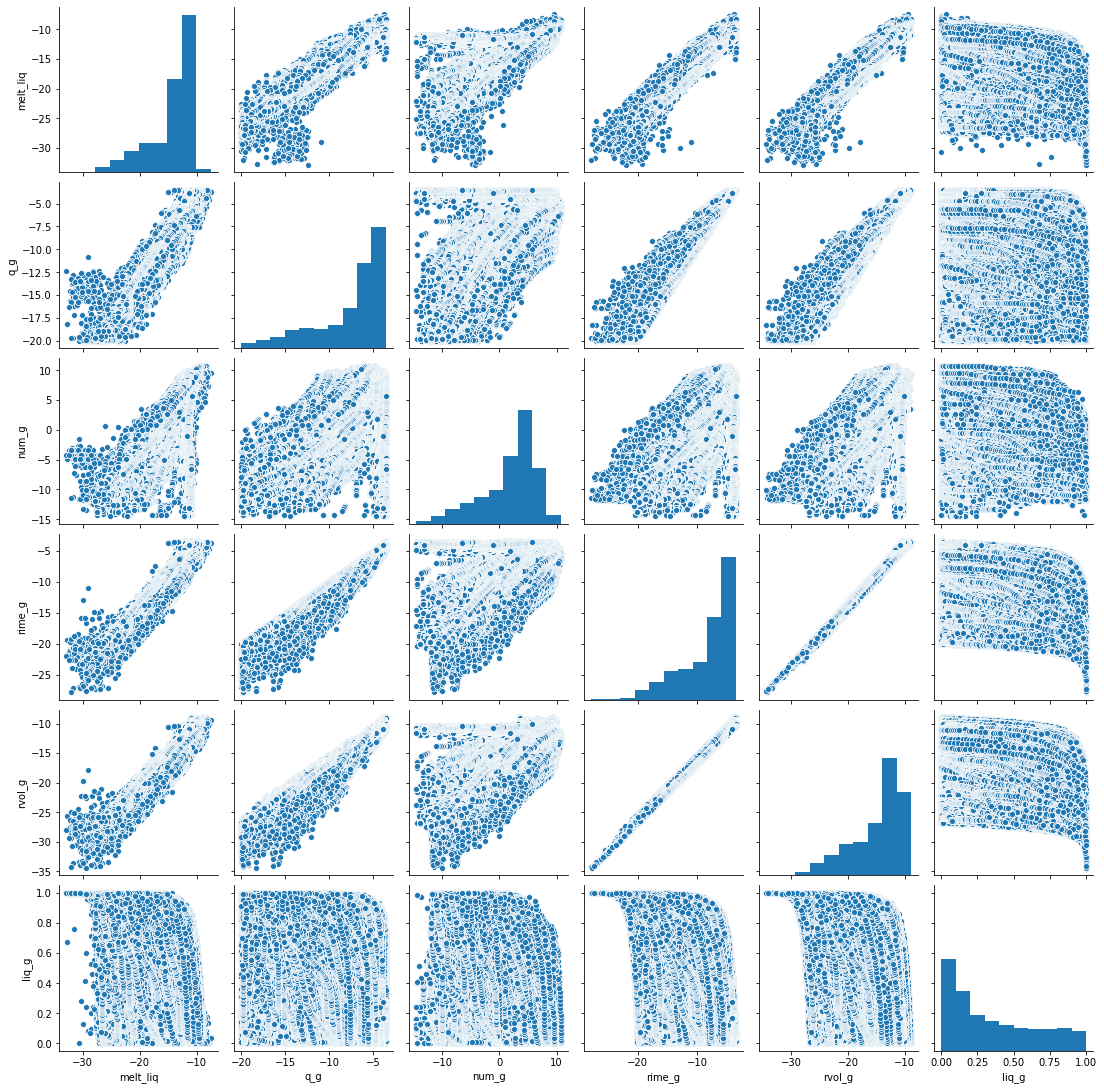

In [18]:
sns.pairplot(dataset_train[["melt_liq","q_g","num_g","rime_g","rvol_g","liq_g"]], diag_kind="hist")

## Separate in different dataset with selected sets of predictors

In [19]:
train_dataset1 = dataset_train.copy()
train_dataset2 = dataset_train.copy()
train_dataset3 = dataset_train.copy()

In [20]:
test_dataset1 = dataset_test.copy()
test_dataset2 = dataset_test.copy()
test_dataset3 = dataset_test.copy()

In [21]:
val_dataset1 = dataset_val.copy()
val_dataset2 = dataset_val.copy()
val_dataset3 = dataset_val.copy()

In [22]:
#train_dataset1 = train_dataset1.drop(['temp'], axis=1)
#train_dataset2 = train_dataset2.drop(['rho'], axis=1)
#train_dataset3 = train_dataset3.drop(['rho'], axis=1)

In [23]:
#test_dataset1 = test_dataset1.drop(['temp'], axis=1)
#test_dataset2 = test_dataset2.drop(['rho'], axis=1)
#test_dataset3 = test_dataset3.drop(['rho'], axis=1)

In [24]:
#val_dataset1 = val_dataset1.drop(['temp'], axis=1)
#val_dataset2 = val_dataset2.drop(['rho'], axis=1)
#val_dataset3 = val_dataset3.drop(['rho'], axis=1)

In [25]:
train_stats1 = train_dataset1.describe()
train_stats1.pop("melt_liq")
train_stats1 = train_stats1.transpose()
train_stats1

count       mean       std        min        25%        50%  \
q_g     558006.0  -7.639491  3.922946 -19.999395  -9.663160  -6.113948   
num_g   558006.0   1.820073  4.755813 -14.498609  -0.632085   3.232581   
rime_g  558006.0  -8.297205  4.290720 -27.786787 -10.849812  -6.718955   
rvol_g  558006.0 -14.879287  4.317201 -34.409679 -17.405369 -13.297699   
liq_g   558006.0   0.351768  0.298755   0.000004   0.093829   0.264113   

              75%        max  
q_g     -4.686511  -3.506558  
num_g    5.166499  10.744515  
rime_g  -4.965039  -3.509128  
rvol_g -11.521676  -8.906318  
liq_g    0.589752   1.000000

In [26]:
train_stats2 = train_dataset2.describe()
train_stats2.pop("melt_liq")
train_stats2 = train_stats2.transpose()
train_stats2

count       mean       std        min        25%        50%  \
q_g     558006.0  -7.639491  3.922946 -19.999395  -9.663160  -6.113948   
num_g   558006.0   1.820073  4.755813 -14.498609  -0.632085   3.232581   
rime_g  558006.0  -8.297205  4.290720 -27.786787 -10.849812  -6.718955   
rvol_g  558006.0 -14.879287  4.317201 -34.409679 -17.405369 -13.297699   
liq_g   558006.0   0.351768  0.298755   0.000004   0.093829   0.264113   

              75%        max  
q_g     -4.686511  -3.506558  
num_g    5.166499  10.744515  
rime_g  -4.965039  -3.509128  
rvol_g -11.521676  -8.906318  
liq_g    0.589752   1.000000

### Split features from labels (here we need only one set of labels)

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [27]:
# pop does not work for multiple columns, use copy instead

labels = ['melt_liq']

train_labels = train_dataset1[labels].copy()
train_dataset1.drop(labels, axis=1, inplace=True)

test_labels = test_dataset1[labels].copy()
test_dataset1.drop(labels, axis=1, inplace=True)

val_labels = val_dataset1[labels].copy()
val_dataset1.drop(labels, axis=1, inplace=True)

In [28]:
train_dataset2.drop(labels, axis=1, inplace=True)
test_dataset2.drop(labels, axis=1, inplace=True)
val_dataset2.drop(labels, axis=1, inplace=True)

In [29]:
train_labels.describe()

melt_liq
count  558006.000000
mean      -14.407462
std         3.757169
min       -32.882854
25%       -15.882174
50%       -12.746377
75%       -11.993696
max        -7.488423

In [30]:
train_dataset1.describe()

q_g          num_g         rime_g         rvol_g  \
count  558006.000000  558006.000000  558006.000000  558006.000000   
mean       -7.639491       1.820073      -8.297205     -14.879287   
std         3.922946       4.755813       4.290720       4.317201   
min       -19.999395     -14.498609     -27.786787     -34.409679   
25%        -9.663160      -0.632085     -10.849812     -17.405369   
50%        -6.113948       3.232581      -6.718955     -13.297699   
75%        -4.686511       5.166499      -4.965039     -11.521676   
max        -3.506558      10.744515      -3.509128      -8.906318   

               liq_g  
count  558006.000000  
mean        0.351768  
std         0.298755  
min         0.000004  
25%         0.093829  
50%         0.264113  
75%         0.589752  
max         1.000000

In [31]:
train_dataset2.describe()

q_g          num_g         rime_g         rvol_g  \
count  558006.000000  558006.000000  558006.000000  558006.000000   
mean       -7.639491       1.820073      -8.297205     -14.879287   
std         3.922946       4.755813       4.290720       4.317201   
min       -19.999395     -14.498609     -27.786787     -34.409679   
25%        -9.663160      -0.632085     -10.849812     -17.405369   
50%        -6.113948       3.232581      -6.718955     -13.297699   
75%        -4.686511       5.166499      -4.965039     -11.521676   
max        -3.506558      10.744515      -3.509128      -8.906318   

               liq_g  
count  558006.000000  
mean        0.351768  
std         0.298755  
min         0.000004  
25%         0.093829  
50%         0.264113  
75%         0.589752  
max         1.000000

### Normalize the features

In [32]:
def norm(x,stats):
  return (x - stats['mean']) / stats['std']

normed_train_data1 = norm(train_dataset1,train_stats1)
normed_train_data2 = norm(train_dataset2,train_stats2)

normed_test_data1 = norm(test_dataset1,train_stats1)
normed_test_data2 = norm(test_dataset2,train_stats2)

normed_val_data1 = norm(val_dataset1,train_stats1)
normed_val_data2 = norm(val_dataset2,train_stats2)

In [33]:
normed_train_stats1 = normed_train_data1.describe()
normed_train_stats1 = normed_train_stats1.transpose()
normed_train_stats1

count          mean  std       min       25%       50%       75%  \
q_g     558006.0 -7.493252e-08  1.0 -3.150669 -0.515855  0.388877  0.752745   
num_g   558006.0  5.801490e-08  1.0 -3.431313 -0.515613  0.297007  0.703650   
rime_g  558006.0  6.463661e-08  1.0 -4.542263 -0.594913  0.367829  0.776598   
rvol_g  558006.0 -4.491544e-07  1.0 -4.523856 -0.585120  0.366346  0.777729   
liq_g   558006.0  1.044331e-08  1.0 -1.177432 -0.863377 -0.293401  0.796584   

             max  
q_g     1.053528  
num_g   1.876534  
rime_g  1.115914  
rvol_g  1.383528  
liq_g   2.169775

In [34]:
normed_train_stats2 = normed_train_data2.describe()
normed_train_stats2 = normed_train_stats2.transpose()
normed_train_stats2

count          mean  std       min       25%       50%       75%  \
q_g     558006.0 -7.493252e-08  1.0 -3.150669 -0.515855  0.388877  0.752745   
num_g   558006.0  5.801490e-08  1.0 -3.431313 -0.515613  0.297007  0.703650   
rime_g  558006.0  6.463661e-08  1.0 -4.542263 -0.594913  0.367829  0.776598   
rvol_g  558006.0 -4.491544e-07  1.0 -4.523856 -0.585120  0.366346  0.777729   
liq_g   558006.0  1.044331e-08  1.0 -1.177432 -0.863377 -0.293401  0.796584   

             max  
q_g     1.053528  
num_g   1.876534  
rime_g  1.115914  
rvol_g  1.383528  
liq_g   2.169775

### Normalize the labels

In [35]:
train_labels_stats = train_labels.describe()
train_labels_stats = train_labels_stats.transpose()
train_labels_stats

count       mean       std        min        25%        50%  \
melt_liq  558006.0 -14.407462  3.757169 -32.882854 -15.882174 -12.746377   

                75%       max  
melt_liq -11.993696 -7.488423

In [36]:
normed_train_labels = norm(train_labels,train_labels_stats)
normed_test_labels = norm(test_labels,train_labels_stats)
normed_val_labels = norm(val_labels,train_labels_stats)

# The model

## Build the model

In [37]:
def build_model_sigm(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='sigmoid', input_shape=[ncol]),
    layers.Dense(nsize, activation='sigmoid'),
    layers.Dense(nsize, activation='sigmoid'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model


def build_model_tanh(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='tanh', input_shape=[ncol]),
    layers.Dense(nsize, activation='tanh'),
    layers.Dense(nsize, activation='tanh'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# scaled exponential linear unit (Klambauer et al. 2015) with LeCun initialization
def build_model_selu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='tanh', input_shape=[ncol]),
    layers.Dense(nsize, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(nsize, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Most common activation piecewise linear function, which should be use with He-initialization
def build_model_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Leaky ReLU with max(alpha*z,z), which helps to avoid dying neurons
def build_model_leaky_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, input_shape=[ncol]),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Parametric leaky ReLU with max(alpha*z,z), but alpha is now a trainable parameter
# This has a strongly increased risk of overfitting!
def build_model_param_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, input_shape=[ncol]),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD_H6(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam_H6(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_model(ncol,nsize,activation,learning_rate):
    if activation == "sigm":
        model = build_model_sigm(ncol,nsize,learning_rate)
    elif activation == "tanh":
        model = build_model_tanh(ncol,nsize,learning_rate)
    elif activation == "SELU":
        model = build_model_selu(ncol,nsize,learning_rate)
    elif activation == "ReLU":
        model = build_model_relu(ncol,nsize,learning_rate)
    elif activation == "ReLU_SGD":
        model = build_model_relu_SGD(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam":
        model = build_model_relu_Adam(ncol,nsize,learning_rate)
    elif activation == "ReLU_SGD_H6":
        model = build_model_relu_SGD_H6(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam_H6":
        model = build_model_relu_Adam_H6(ncol,nsize,learning_rate)
    elif activation == "LReLU":
        model = build_model_leaky_relu(ncol,nsize,learning_rate)
    elif activation == "PReLU":
        model = build_model_param_relu(ncol,nsize,learning_rate)
    else:
        print("Error: Wrong choice for activation")
    return model        

In [38]:

activ = "sigm"
    
#activ = "PReLU"
#activ = "LReLU"
#activ = "tanh"
#activ = "ReLU_SGD"
#activ = "ReLU_Adam"
#activ = "ReLU"

model = build_model(5,16,activ,1e-3)

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                96        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 657
Trainable params: 657
Non-trainable params: 0
_________________________________________________________________


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [40]:
example_batch  = normed_train_data1[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.8492382 ],
       [-0.849025  ],
       [-0.8486867 ],
       [-0.84850055],
       [-0.84828293],
       [-0.8480339 ],
       [-0.8477539 ],
       [-0.8474433 ],
       [-0.8471021 ],
       [-0.84673166]], dtype=float32)

It seems to be working, if it produces a result of the expected shape and type and no NaN.

# Train the model

Use early stopping

In [41]:
# maximum number, but we use early stopping
EPOCHS = 300

# learning rate
learn = 1e-3       # original value is 1e-3, but smaller might be better?

# width of neural net
nsize = 16

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=10)

# for collecting the histories
histories = {}

# make plots bigger than standard layout
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

In [42]:
activ = "sigm"
model1 = build_model(len(normed_train_data1.keys()),nsize,activ,learn)

early_history1 = model1.fit(normed_train_data1, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data1,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0214,  mae:0.0770,  mse:0.0214,  val_loss:0.0055,  val_mae:0.0504,  val_mse:0.0055,  
.................................................

Text(0, 0.5, 'MAE')

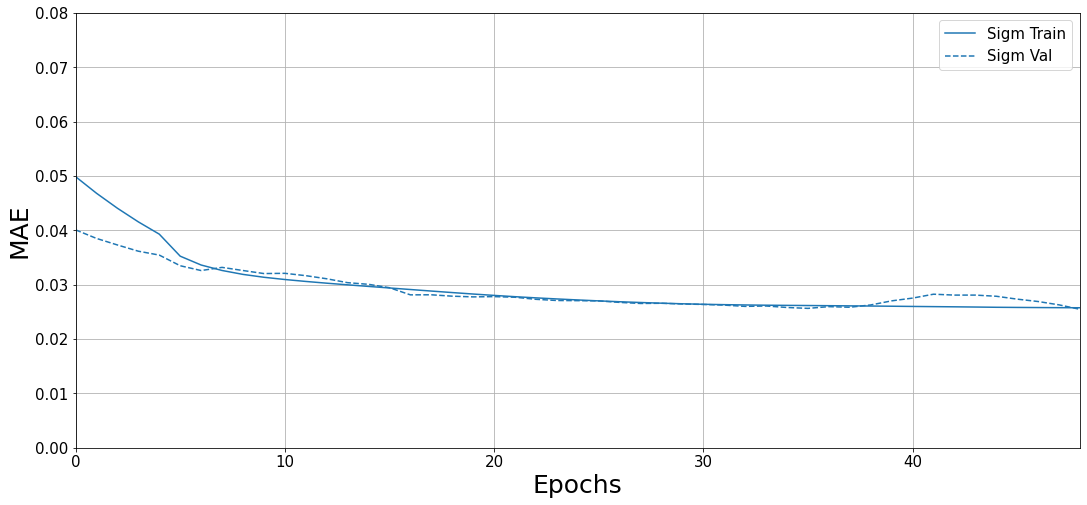

In [44]:
histories['sigm'] = early_history1

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.0, 0.08])
plt.ylabel('MAE')

In [45]:
activ = "ReLU"
model2 = build_model(len(normed_train_data2.keys()),nsize,activ,learn)

early_history2 = model2.fit(normed_train_data2, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data2,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0038,  mae:0.0315,  mse:0.0038,  val_loss:0.0041,  val_mae:0.0362,  val_mse:0.0041,  
.............................................

Text(0, 0.5, 'MAE')

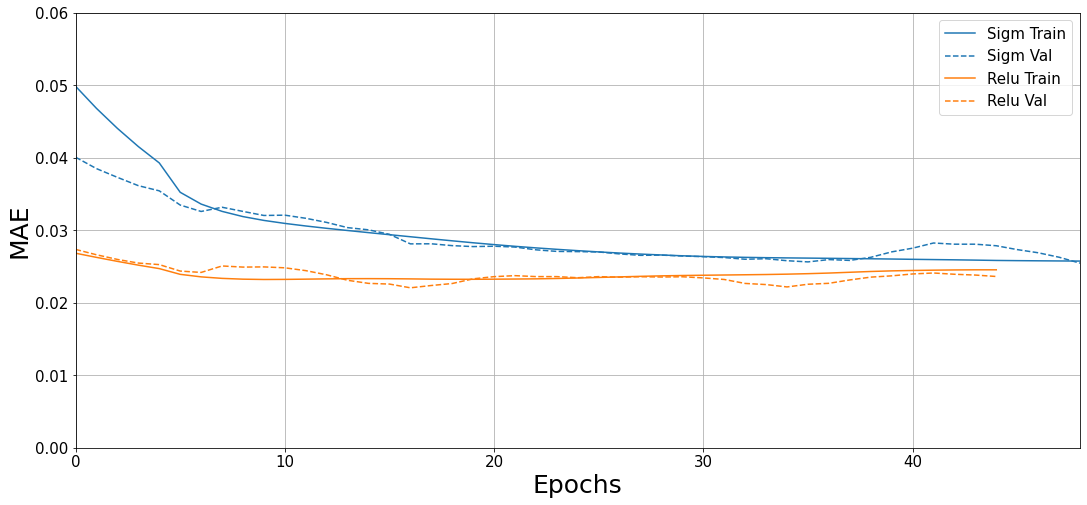

In [46]:
histories['ReLU'] = early_history2

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0., 0.06])
plt.ylabel('MAE')

In [47]:
activ = "ReLU_Adam"
model3 = build_model(len(normed_train_data2.keys()),nsize,activ,learn)

early_history3 = model3.fit(normed_train_data2, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data2,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0050,  mae:0.0346,  mse:0.0050,  val_loss:0.0028,  val_mae:0.0290,  val_mse:0.0028,  
...................

Text(0, 0.5, 'MAE')

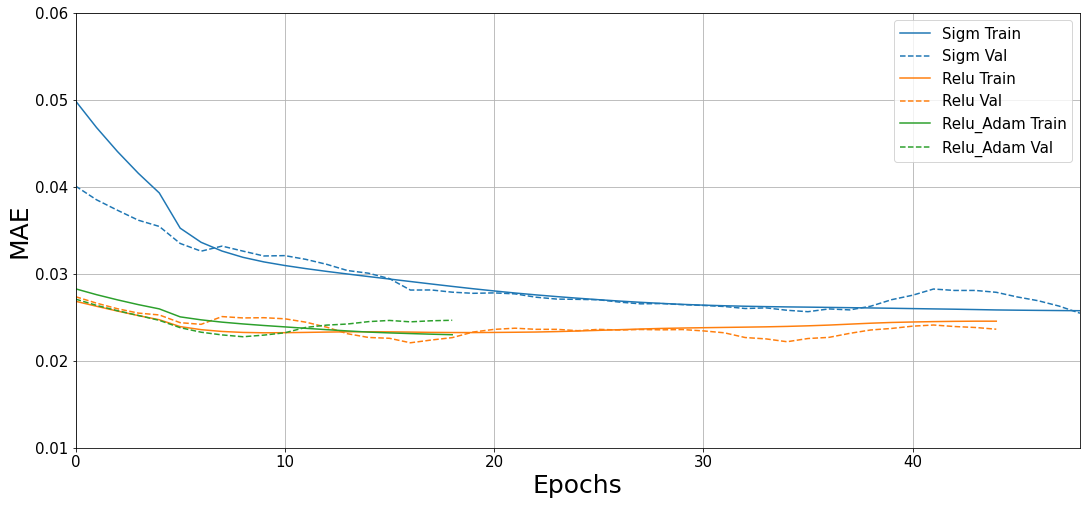

In [48]:
histories['ReLU_Adam'] = early_history3

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.01, 0.06])
plt.ylabel('MAE')

In [49]:
nsize = 32
activ = "ReLU_Adam"
model4 = build_model(len(normed_train_data2.keys()),nsize,activ,learn)

early_history4 = model4.fit(normed_train_data2, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data2,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0032,  mae:0.0292,  mse:0.0032,  val_loss:0.0025,  val_mae:0.0257,  val_mse:0.0025,  
...............................

Text(0, 0.5, 'MAE')

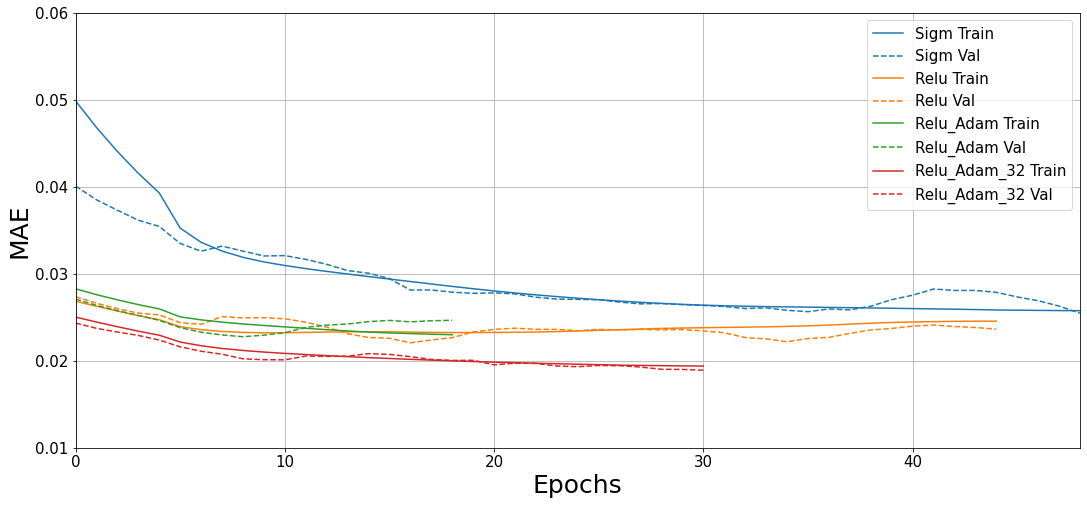

In [50]:
histories['ReLU_Adam_32'] = early_history4

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.01, 0.06])
plt.ylabel('MAE')

Text(0, 0.5, 'MSE')

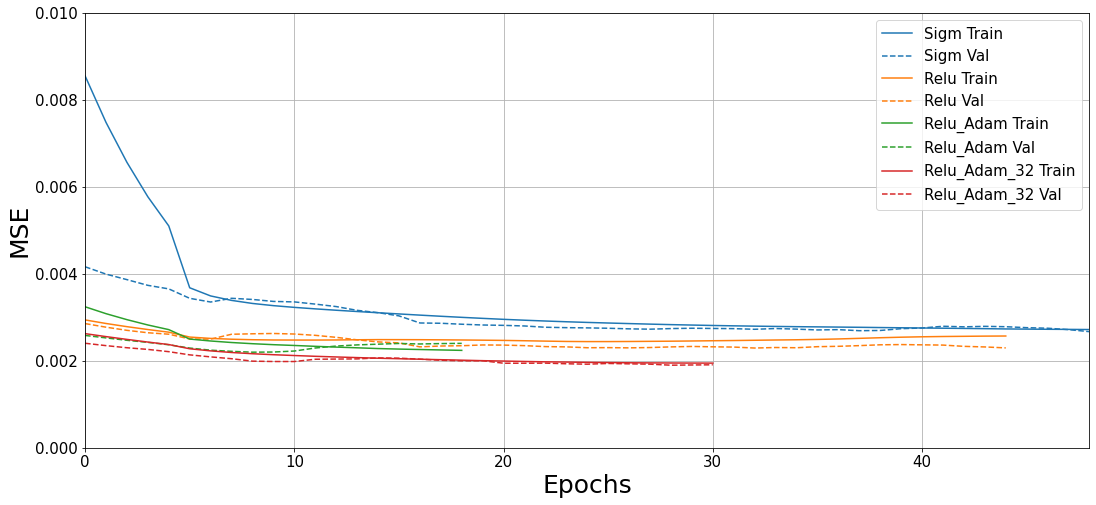

In [51]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mse")
plt.ylim([0.0, 0.01])
plt.ylabel('MSE')

In [52]:
loss1, mae1, mse1 = model1.evaluate(normed_test_data1, normed_test_labels, verbose=2)

print("Testing set for model 1, Mean Abs Error: {:10.5f}".format(mae1))

119939/119939 - 3s - loss: 0.0024 - mae: 0.0236 - mse: 0.0024
Testing set for model 1, Mean Abs Error:    0.02364


In [53]:
loss2, mae2, mse2 = model2.evaluate(normed_test_data2, normed_test_labels, verbose=2)

print("Testing set for model 2, Mean Abs Error: {:20.5f}".format(mae2))

119939/119939 - 3s - loss: 0.0020 - mae: 0.0204 - mse: 0.0020
Testing set for model 2, Mean Abs Error:              0.02042


In [54]:
loss3, mae3, mse3 = model3.evaluate(normed_test_data2, normed_test_labels, verbose=2)

print("Testing set for model 3, Mean Abs Error: {:20.5f}".format(mae3))

119939/119939 - 3s - loss: 0.0020 - mae: 0.0225 - mse: 0.0020
Testing set for model 3, Mean Abs Error:              0.02251


In [55]:
loss4, mae4, mse4 = model4.evaluate(normed_test_data2, normed_test_labels, verbose=2)

print("Testing set for model 4, Mean Abs Error: {:20.5f}".format(mae4))

119939/119939 - 3s - loss: 0.0017 - mae: 0.0180 - mse: 0.0017
Testing set for model 4, Mean Abs Error:              0.01801


In [56]:
mae = [ mae1, mae2, mae3, mae4 ]
mae

[0.023638127, 0.020416206, 0.022507597, 0.018013094]

In [57]:
mse = [ mse1, mse2, mse3, mse4 ]
mse

[0.002377288, 0.001954231, 0.002020973, 0.0017032383]

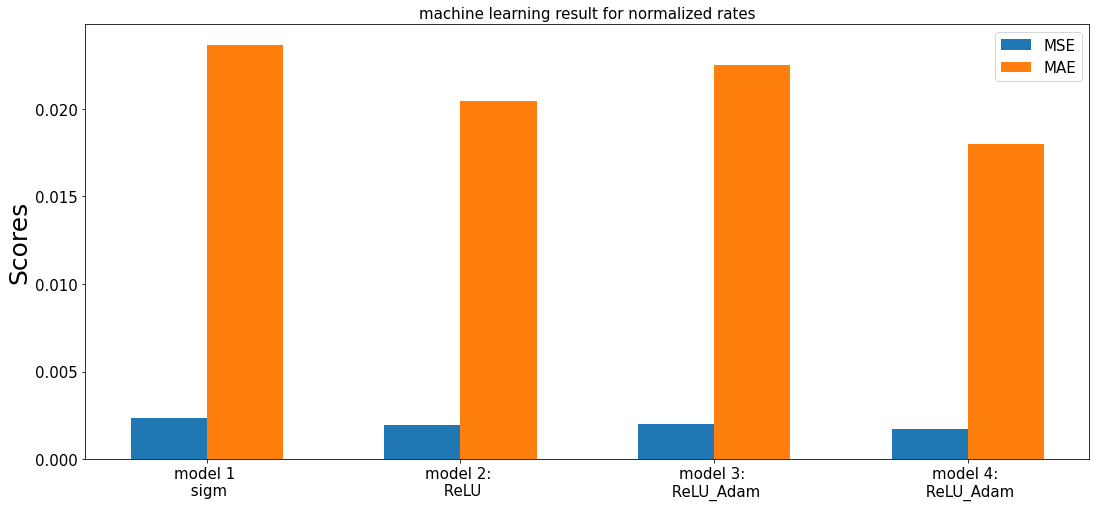

In [58]:
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

labels = ['model 1 \n sigm',
 'model 2: \n ReLU',
 'model 3: \n ReLU_Adam',
 'model 4: \n ReLU_Adam' ]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mse, width, label='MSE')
rects2 = ax.bar(x + width/2, mae, width, label='MAE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('machine learning result for normalized rates')
ax.set_xticks(x)
ax.set_xticklabels(labels)
#ax.set_ylim(0,3e-8)
ax.legend()

#fig.tight_layout()

plt.show()

# Make predictions

Finally, predict the values using data in the testing set:

In [59]:
test_true_liq  = np.exp(test_labels.pop('melt_liq'))

In [60]:
def backtransform(x,stats):
  return x*stats['std']+stats['mean']

In [61]:
labels = [ "melt_liq" ]

p1 = pd.DataFrame(data=model1.predict(normed_test_data1), columns=labels)

In [62]:
p1.describe()

melt_liq
count  119939.000000
mean       -0.004655
std         1.005355
min        -4.219405
25%        -0.397427
50%         0.446357
75%         0.644750
max         1.525702

In [63]:
train_labels_stats

count       mean       std        min        25%        50%  \
melt_liq  558006.0 -14.407462  3.757169 -32.882854 -15.882174 -12.746377   

                75%       max  
melt_liq -11.993696 -7.488423

In [64]:
test_predict1 = np.exp(backtransform(p1,train_labels_stats))

In [65]:
test_predict1.describe()

melt_liq
count  1.199390e+05
mean   4.929316e-06
std    8.644241e-06
min    7.211744e-14
25%    1.242883e-07
50%    2.959703e-06
75%    6.236892e-06
max    1.707788e-04

In [66]:
np.exp(test_dataset1.head())

q_g   num_g        rime_g        rvol_g     liq_g
107  0.000001  5.9688  9.294801e-07  2.157600e-09  1.096375
113  0.000001  5.9062  8.323403e-07  1.922200e-09  1.200637
116  0.000001  5.7188  7.738499e-07  1.788300e-09  1.267022
118  0.000001  5.7188  7.350402e-07  1.695000e-09  1.318671
125  0.000001  5.5156  5.520301e-07  1.274200e-09  1.553114

In [67]:
test_predict1.head()

melt_liq
0  2.024512e-08
1  1.924541e-08
2  1.832607e-08
3  1.794255e-08
4  1.615619e-08

In [68]:
test_dataset2.head()

q_g     num_g     rime_g     rvol_g     liq_g
107 -13.749536  1.786546 -13.888640 -19.954269  0.092009
113 -13.754321  1.776003 -13.999024 -20.069796  0.182852
116 -13.759036  1.743759 -14.071888 -20.142000  0.236669
118 -13.756770  1.743759 -14.123341 -20.195583  0.276624
125 -13.786437  1.707580 -14.409663 -20.480947  0.440262

In [69]:
test_predict1_liq   = test_predict1['melt_liq']

In [70]:
p4 = pd.DataFrame(data=model3.predict(normed_test_data2), columns=labels)

test_predict4 = np.exp(backtransform(p4,train_labels_stats))

test_predict4_liq   = test_predict4['melt_liq']

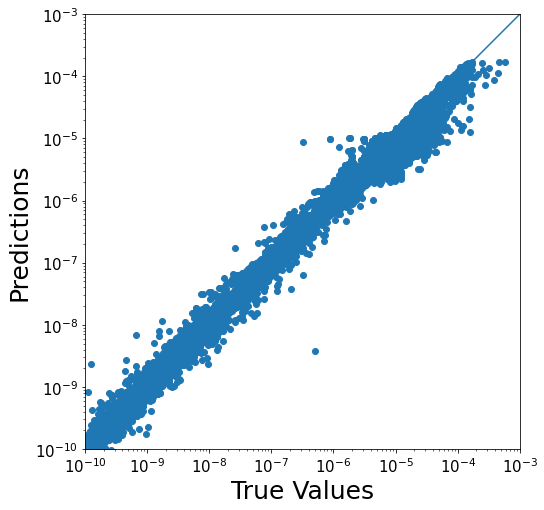

In [71]:
amin, amax = 1e-10, 1e-3

a = plt.axes(aspect='equal')
plt.scatter(test_true_liq, test_predict1_liq)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

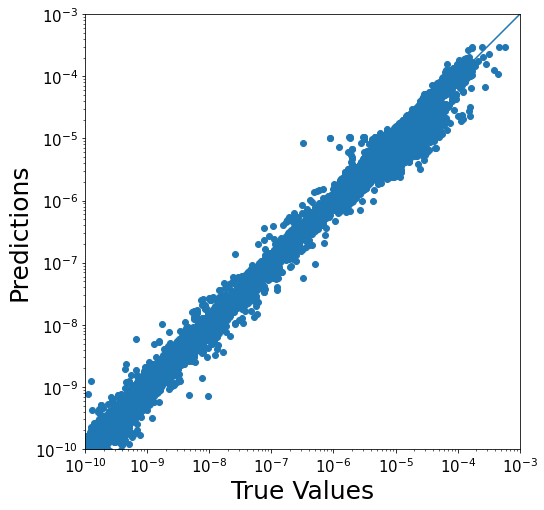

In [72]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_liq, test_predict4_liq)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# Save models to file

In [73]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model_v2
version

'14'

In [74]:
def save2netcdf(model, features_str, labels_str, features_norm, labels_norm, features_ltf, outpath, verbose=True):
    # borrowed from Fabian Jakub, LMU Munich
    # https://github.com/tenstream/tenstream/blob/master/misc/LUT_to_Keras.py

    if model is None:
        D = xr.Dataset()
        D.to_netcdf(outpath)
        return

    layers = [ l for l in model.layers if 'Dropout' not in str(type(l)) ]
    if verbose:
        print("Saving model to "+outpath)
        print("  Features:   "+features_str)
        print("  Labels:     "+labels_str)
        for i,l in enumerate(layers):
            print("  Layer {}: {}, {}, Activation: {}".format(i, str(type(l)), l.weights[0].shape,l.activation.__name__))

    D = xr.Dataset()
    D.attrs['Nlayer'] = np.int32(len(layers))
    D.attrs['features']  = features_str
    D.attrs['labels'] = labels_str
    D.attrs['keras_name'] = model.name

    for i, l in enumerate(layers):
        D["w{}".format(i)] = xr.DataArray(l.weights[0].numpy(), dims=("Ninp_{}".format(i), "Nout_{}".format(i)))
        D["b{}".format(i)] = xr.DataArray(l.weights[1].numpy(), dims=("Nout_{}".format(i)))
        D["w{}".format(i)].attrs['activation'] = l.activation.__name__

    # write arrays for logtransform and normalization of input and output data to netcdf
    nout = len(layers)-1
    D["inp_logtransform"] = xr.DataArray(features_ltf, dims=("Ninp_0"))
    D["inp_norm_mean"] = xr.DataArray(features_norm['mean'].values, dims=("Ninp_0"))
    D["inp_norm_std"]  = xr.DataArray(features_norm['std'].values, dims=("Ninp_0"))
    D["out_norm_mean"] = xr.DataArray(labels_norm['mean'].values, dims=("Nout_{}".format(nout)))
    D["out_norm_std"]  = xr.DataArray(labels_norm['std'].values, dims=("Nout_{}".format(nout)))
    
    D.to_netcdf(outpath)

In [75]:
features = 'q_graupel, n_graupel, rmass_graupel, rvol_graupel, liq_fraction'
labels   = 'melt_liq, scaled with deltaT'
filename = 'saved_model_v2/melt_graupel_model2_'+version+'.nc'
logtransform = np.array([True, True, True, True, False], dtype=bool)
save2netcdf(model2,features,labels,train_stats1,train_labels_stats,logtransform,filename)

Saving model to saved_model_v2/melt_graupel_model2_14.nc
  Features:   q_graupel, n_graupel, rmass_graupel, rvol_graupel, liq_fraction
  Labels:     melt_liq, scaled with deltaT
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (5, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 1), Activation: linear


In [76]:
filename = 'saved_model_v2/melt_graupel_model3_'+version+'.nc'
save2netcdf(model3,features,labels,train_stats2,train_labels_stats,logtransform,filename)

Saving model to saved_model_v2/melt_graupel_model3_14.nc
  Features:   q_graupel, n_graupel, rmass_graupel, rvol_graupel, liq_fraction
  Labels:     melt_liq, scaled with deltaT
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (5, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 1), Activation: linear


In [77]:
filename = 'saved_model_v2/melt_graupel_model4_'+version+'.nc'
save2netcdf(model4,features,labels,train_stats2,train_labels_stats,logtransform,filename)

Saving model to saved_model_v2/melt_graupel_model4_14.nc
  Features:   q_graupel, n_graupel, rmass_graupel, rvol_graupel, liq_fraction
  Labels:     melt_liq, scaled with deltaT
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (5, 32), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (32, 32), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (32, 32), Activation: relu
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (32, 1), Activation: linear


In [78]:
train_stats2

count       mean       std        min        25%        50%  \
q_g     558006.0  -7.639491  3.922946 -19.999395  -9.663160  -6.113948   
num_g   558006.0   1.820073  4.755813 -14.498609  -0.632085   3.232581   
rime_g  558006.0  -8.297205  4.290720 -27.786787 -10.849812  -6.718955   
rvol_g  558006.0 -14.879287  4.317201 -34.409679 -17.405369 -13.297699   
liq_g   558006.0   0.351768  0.298755   0.000004   0.093829   0.264113   

              75%        max  
q_g     -4.686511  -3.506558  
num_g    5.166499  10.744515  
rime_g  -4.965039  -3.509128  
rvol_g -11.521676  -8.906318  
liq_g    0.589752   1.000000